In [ ]:
# Analysis with Univariate Long Short Term Memory (LSTM) on 2019 - 2020 data: Forecasting ED patient arrival

In [ ]:
from google.colab import files
uploaded = files.upload()

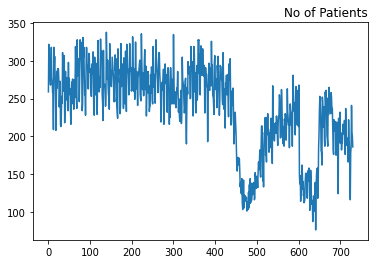

In [ ]:
import pandas as pd
from matplotlib import pyplot
# load dataset
dataset = pd.read_excel('Time series data_2019_2020.xlsx', header=0, index_col=0)
#dataset = read_csv('Time series data_neww.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=1, loc='right')
    i += 1
pyplot.show()

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# load dataset
dataset = pd.read_excel('Time series data_2019_2020.xlsx', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.698473  0.938931
2   0.938931  0.835878
3   0.835878  0.828244
4   0.828244  0.767176
5   0.767176  0.732824


In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 670 # My code, n_train = 365 * 2 or 710 days
train = values[:n_train_hours, :] # 8760 hours for train. My code train = 710 days
test = values[n_train_hours:, :] # 35039 hours for test. My code test = 21 days
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(670, 1, 1) (670,) (60, 1, 1) (60,)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 - 2s - loss: 0.5746 - val_loss: 0.4203
Epoch 2/100
10/10 - 0s - loss: 0.5216 - val_loss: 0.3702
Epoch 3/100
10/10 - 0s - loss: 0.4658 - val_loss: 0.3163
Epoch 4/100
10/10 - 0s - loss: 0.4070 - val_loss: 0.2599
Epoch 5/100
10/10 - 0s - loss: 0.3466 - val_loss: 0.2000
Epoch 6/100
10/10 - 0s - loss: 0.2847 - val_loss: 0.1379
Epoch 7/100
10/10 - 0s - loss: 0.2244 - val_loss: 0.0870
Epoch 8/100
10/10 - 0s - loss: 0.1704 - val_loss: 0.0794
Epoch 9/100
10/10 - 0s - loss: 0.1312 - val_loss: 0.101

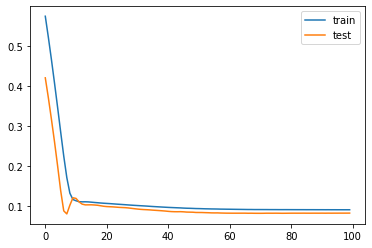

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network - tuning epochs = 100, batch_size = 10(72)
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE, MAE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 27.984
Test MAE: 21.335


<Figure size 432x288 with 0 Axes>

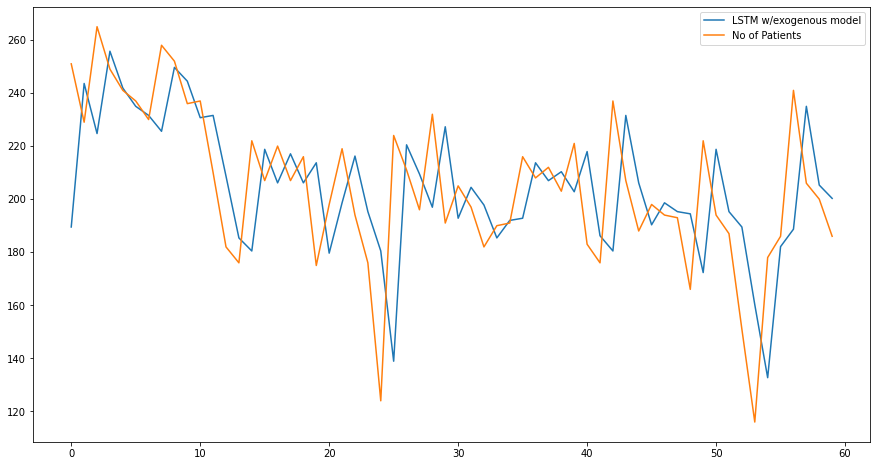

In [ ]:
# plot baseline and predictions
pyplot.clf()
pyplot.figure(figsize=(15,8))
pyplot.plot(inv_yhat, label="LSTM w/exogenous model")
pyplot.plot(inv_y, label="No of Patients")
pyplot.legend()
pyplot.show()

In [ ]:
y_predict =list(inv_yhat)

In [ ]:
y_predict

[189.50488,
 243.60023,
 224.72617,
 255.7506,
 241.87312,
 234.98694,
 231.55745,
 225.57802,
 249.66231,
 244.4646,
 230.70148,
 231.55745,
 208.65529,
 185.38782,
 180.4697,
 218.77979,
 206.1381,
 217.08624,
 206.1381,
 213.70645,
 179.65242,
 198.62097,
 216.24037,
 195.29681,
 180.4697,
 138.92311,
 220.47575,
 209.49557,
 196.9576,
 227.28352,
 192.81062,
 204.46315,
 197.78897,
 185.38782,
 191.98317,
 192.81062,
 213.70645,
 206.97653,
 210.33652,
 202.79076,
 217.93272,
 186.20987,
 180.4697,
 231.55745,
 206.1381,
 190.33032,
 198.62097,
 195.29681,
 194.46742,
 172.32808,
 218.77979,
 195.29681,
 189.50488,
 160.24846,
 132.71144,
 182.10635,
 188.68015,
 234.98694,
 205.30032,
 200.28696]

In [ ]:
# list out all the RMSE values with their various epoch and create a line chart